# Building an End-to-End Automatic Speech Recognition Model From Scratch

## Speech Data

Import Amharic speech data

In [ ]:
!git clone https://github.com/getalp/ALFFA_PUBLIC.git

Cloning into 'ALFFA_PUBLIC'...
remote: Enumerating objects: 66044, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 66044 (delta 8), reused 1 (delta 0), pack-reused 66024 (from 1)
Receiving objects: 100% (66044/66044), 6.54 GiB | 22.82 MiB/s, done.
Resolving deltas: 100% (12345/12345), done.
Updating files: 100% (56926/56926), done.


Format data into a csv with the transcript and audio file path

In [ ]:
import pandas as pd
import numpy as np
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define directory paths
audio_root = "/content/ALFFA_PUBLIC/ASR/AMHARIC/data/"
train_root = audio_root + "train/wav/"
test_root = audio_root + "test/wav/"
train_csv = "/content/train_trans.csv"
test_csv = "/content/valid_trans.csv"

# Create DataFrame from csv labeling transcriptions and name of files
train_df = pd.read_csv(train_csv, header=None, names=["transcript", "name"])
test_df = pd.read_csv(test_csv, header=None, names=["transcript", "name"])

# Add full file path as separate column
train_df["path"] = train_root + train_df["name"] + ".wav"
test_df["path"] = test_root + test_df["name"] + ".wav"

# Save dataframe as csv
train_df.to_csv("train-transcript-files.csv")
test_df.to_csv("test-transcript-files.csv")

train_df.head()

,transcript,name,path
0,ያንደኛ ደረጃ ትምህርታቸው ን ጐንደር ተ ም ረዋል,tr_1_tr01001,/content/ALFFA_PUBLIC/ASR/AMHARIC/data/train/w...
1,የተ ለቀቁት ምርኮኞች በ አካባቢያቸው ሰላማዊ ኑሮ እንዲ ኖሩ የ ትራንስፖ...,tr_2_tr01002,/content/ALFFA_PUBLIC/ASR/AMHARIC/data/train/w...
2,በ አዲስ አበባው ስታዲየም በ ተካሄዱ ት ሁለት ግጥሚያ ዎች በ መጀመሪያ ...,tr_3_tr01003,/content/ALFFA_PUBLIC/ASR/AMHARIC/data/train/w...
3,ወሬው ን ወሬ ያደረጉ ምስጢረ ኞች ናቸው,tr_4_tr01004,/content/ALFFA_PUBLIC/ASR/AMHARIC/data/train/w...
4,ኢትዮጵያዊ ቷ በ ብሄራዊ ባህላዊ አለባበስ ከ አለም አንደኝነት ን ተቀዳጀ ች,tr_5_tr01005,/content/ALFFA_PUBLIC/ASR/AMHARIC/data/train/w...


## Audio preprocessing

Plot the waveform of a random audio signal with its transcription

Transcription: የ ም ፈልገው ን ሞት ላ ገኘው እንደሆነ ጠረጠር ኩ


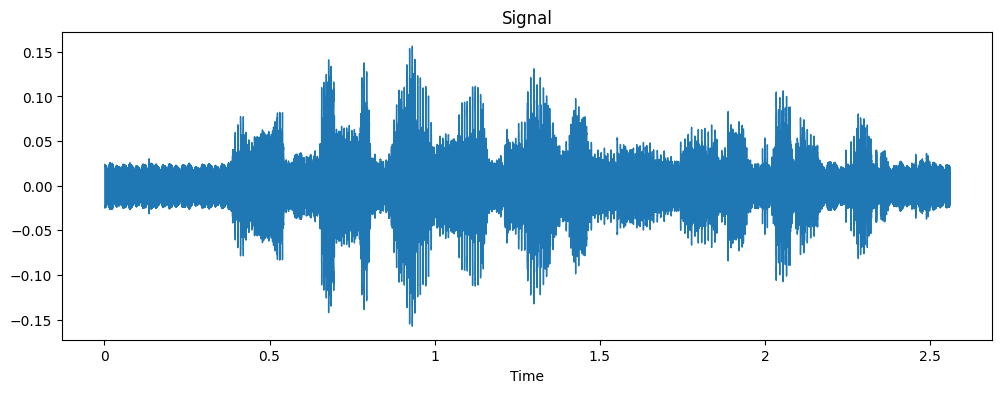

In [ ]:
idx = np.random.randint(0, len(train_df["path"]))
samples, sample_rate = librosa.load(train_df["path"][idx])
print(f"Transcription:", train_df["transcript"][idx])

plt.figure(figsize=(12, 4))
librosa.display.waveshow(samples, sr=sample_rate)
plt.title("Signal")
plt.show()

What does it sound like?

In [ ]:
import IPython
IPython.display.Audio(train_df["path"][idx])

Z-score normalization of signal to minimize background noise

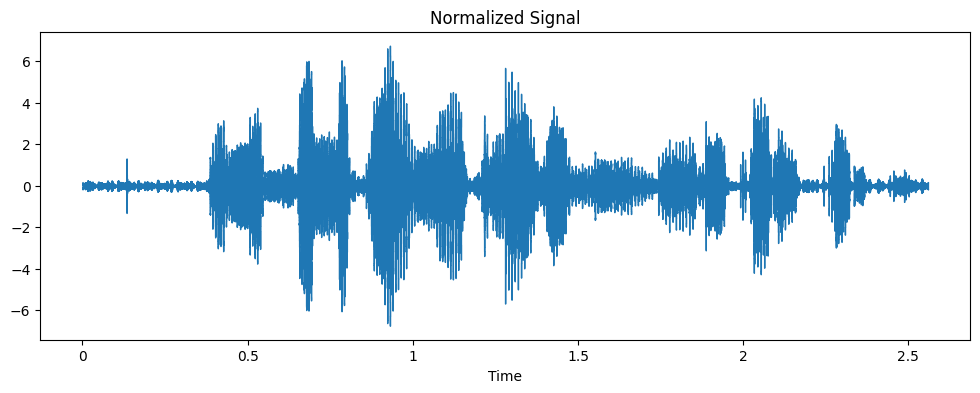

In [ ]:
mean = np.mean(samples)
std = np.std(samples)
norm_samples = (samples - mean) / std

plt.figure(figsize=(12, 4))
librosa.display.waveshow(norm_samples, sr=sample_rate)
plt.title("Normalized Signal")
plt.show()

Trim beginning and end background noise from signal

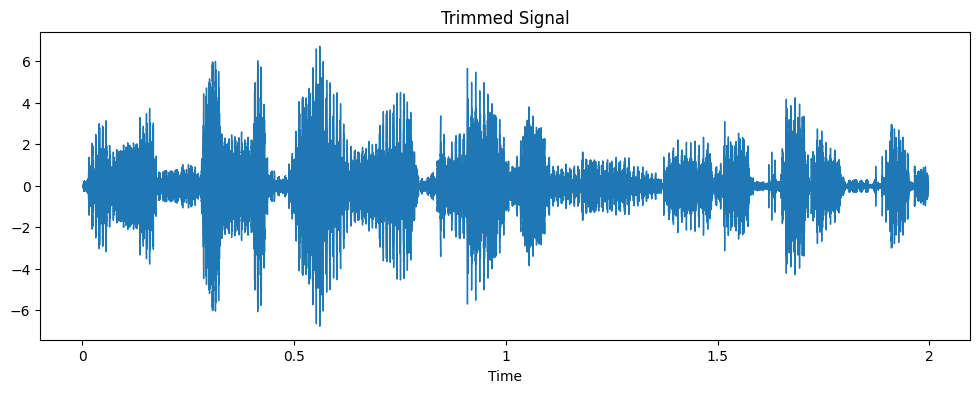

In [ ]:
trim_signal, _ = librosa.effects.trim(norm_samples, top_db=15) # Tune the threshold decibels defining silence, found that 15 is a good starting point

plt.figure(figsize=(12, 4))
librosa.display.waveshow(trim_signal, sr=sample_rate)
plt.title("Trimmed Signal")
plt.show()

Resample the audio signal to 8000 Hz

In [ ]:
signal = librosa.resample(trim_signal, orig_sr=16000, target_sr=8000)
print(f'Original signal shape = {trim_signal.shape[0]} \nResampled signal shape = {signal.shape[0]}')

Original signal shape = 44032 
Resampled signal shape = 22016


Compute a spectrogram from the waveform

Features = 40


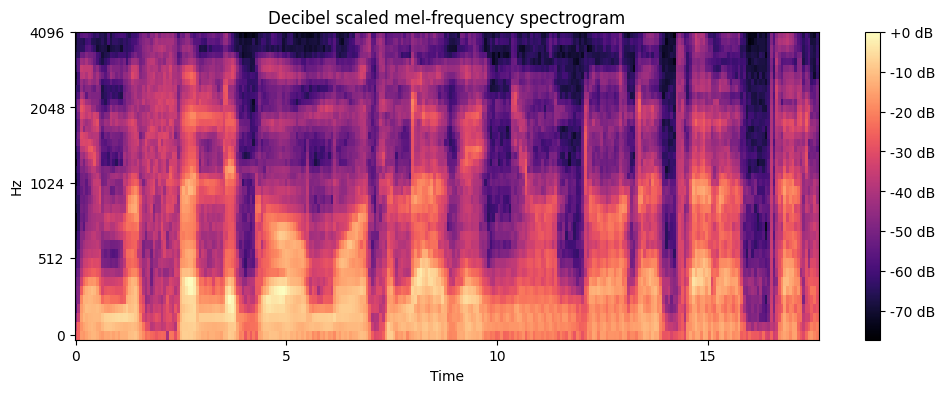

In [ ]:
spectrogram = librosa.feature.melspectrogram(
    y=signal,
    sr=8000, # sample rate
    n_fft=512, # n-point FFT
    hop_length=80, # frame step allows overlap to frames 10ms (=0.01*sr)
    win_length=200, # frame signal into 25 ms windows (0.025*sr)
    n_mels=40,
    fmin=20, # Low-frequency limit (Hz)
    fmax=4000 # High-frequency limit (=sr/2)
)

S_DB = librosa.power_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(S_DB, sr=8000, x_axis='time', y_axis='mel')
print(f"Features = {S_DB.shape[0]}")
plt.colorbar(format='%+2.0f dB')
plt.title("Decibel scaled mel-frequency spectrogram")
plt.show()

In [ ]:
spectrogram.shape

(40, 276)

Compute the compressed representation of the spectrogram - mel frequency cepstral coefficients

Features = 13


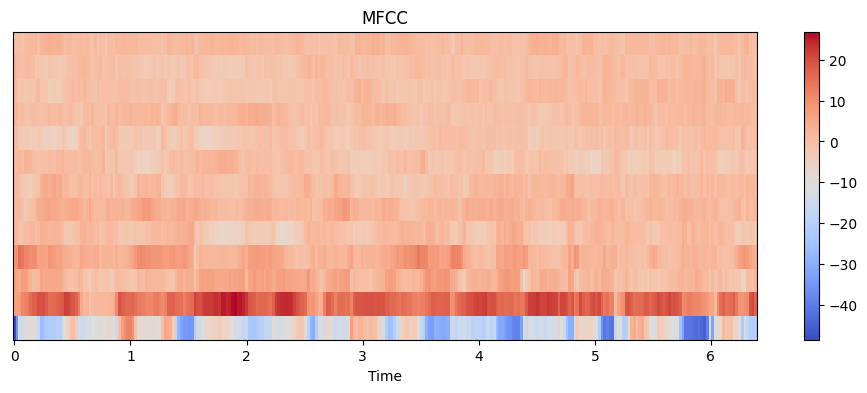

In [ ]:
mfcc = librosa.feature.mfcc(S=np.log(spectrogram), n_mfcc=13) # documentation calls for input to be log-scaled, thus can't use .power_to_db()
print(f"Features = {mfcc.shape[0]}")
plt.figure(figsize=(12, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC")
plt.show()

## Tokenization

Import all characters used in Amharic from unicode standard

In [ ]:
import unicodedata

ethiopic_base_blocks = [
    (0x1200, 0x137F),  # Main Ethiopic block (see: https://www.ssec.wisc.edu/~tomw/java/unicode.html)
]

characters = []
for block_start, block_end in ethiopic_base_blocks:
    for codepoint in range(block_start, block_end + 1):
        ch = chr(codepoint)
        name = unicodedata.name(ch, "")
        if "ETHIOPIC SYLLABLE" in name:
            characters.append(ch)

In [ ]:
print(characters)

['ሀ', 'ሁ', 'ሂ', 'ሃ', 'ሄ', 'ህ', 'ሆ', 'ሇ', 'ለ', 'ሉ', 'ሊ', 'ላ', 'ሌ', 'ል', 'ሎ', 'ሏ', 'ሐ', 'ሑ', 'ሒ', 'ሓ', 'ሔ', 'ሕ', 'ሖ', 'ሗ', 'መ', 'ሙ', 'ሚ', 'ማ', 'ሜ', 'ም', 'ሞ', 'ሟ', 'ሠ', 'ሡ', 'ሢ', 'ሣ', 'ሤ', 'ሥ', 'ሦ', 'ሧ', 'ረ', 'ሩ', 'ሪ', 'ራ', 'ሬ', 'ር', 'ሮ', 'ሯ', 'ሰ', 'ሱ', 'ሲ', 'ሳ', 'ሴ', 'ስ', 'ሶ', 'ሷ', 'ሸ', 'ሹ', 'ሺ', 'ሻ', 'ሼ', 'ሽ', 'ሾ', 'ሿ', 'ቀ', 'ቁ', 'ቂ', 'ቃ', 'ቄ', 'ቅ', 'ቆ', 'ቇ', 'ቈ', 'ቊ', 'ቋ', 'ቌ', 'ቍ', 'ቐ', 'ቑ', 'ቒ', 'ቓ', 'ቔ', 'ቕ', 'ቖ', 'ቘ', 'ቚ', 'ቛ', 'ቜ', 'ቝ', 'በ', 'ቡ', 'ቢ', 'ባ', 'ቤ', 'ብ', 'ቦ', 'ቧ', 'ቨ', 'ቩ', 'ቪ', 'ቫ', 'ቬ', 'ቭ', 'ቮ', 'ቯ', 'ተ', 'ቱ', 'ቲ', 'ታ', 'ቴ', 'ት', 'ቶ', 'ቷ', 'ቸ', 'ቹ', 'ቺ', 'ቻ', 'ቼ', 'ች', 'ቾ', 'ቿ', 'ኀ', 'ኁ', 'ኂ', 'ኃ', 'ኄ', 'ኅ', 'ኆ', 'ኇ', 'ኈ', 'ኊ', 'ኋ', 'ኌ', 'ኍ', 'ነ', 'ኑ', 'ኒ', 'ና', 'ኔ', 'ን', 'ኖ', 'ኗ', 'ኘ', 'ኙ', 'ኚ', 'ኛ', 'ኜ', 'ኝ', 'ኞ', 'ኟ', 'አ', 'ኡ', 'ኢ', 'ኣ', 'ኤ', 'እ', 'ኦ', 'ኧ', 'ከ', 'ኩ', 'ኪ', 'ካ', 'ኬ', 'ክ', 'ኮ', 'ኯ', 'ኰ', 'ኲ', 'ኳ', 'ኴ', 'ኵ', 'ኸ', 'ኹ', 'ኺ', 'ኻ', 'ኼ', 'ኽ', 'ኾ', 'ዀ', 'ዂ', 'ዃ', 'ዄ', 'ዅ', 'ወ', 'ዉ', 'ዊ', 'ዋ', 'ዌ', 'ው', 'ዎ', 'ዏ', 'ዐ', 'ዑ', 'ዒ', 'ዓ', 'ዔ', 'ዕ', 'ዖ', 'ዘ', 'ዙ',

Create dictionaries which map characters to integers and the reverse

In [ ]:
# Each character corresponds to an integer
char_map = {}
char_map[""] = 0
char_map["<SPACE>"] = 1
index = 2
for c in characters:
  char_map[c] = index
  index += 1

# Each integer corresponds to a character (just flip char_map)
index_map = {}
for key in char_map.keys():
  index_map[char_map[key]] = key

In [ ]:
print(char_map)
print(index_map)

{'': 0, '<SPACE>': 1, 'ሀ': 2, 'ሁ': 3, 'ሂ': 4, 'ሃ': 5, 'ሄ': 6, 'ህ': 7, 'ሆ': 8, 'ሇ': 9, 'ለ': 10, 'ሉ': 11, 'ሊ': 12, 'ላ': 13, 'ሌ': 14, 'ል': 15, 'ሎ': 16, 'ሏ': 17, 'ሐ': 18, 'ሑ': 19, 'ሒ': 20, 'ሓ': 21, 'ሔ': 22, 'ሕ': 23, 'ሖ': 24, 'ሗ': 25, 'መ': 26, 'ሙ': 27, 'ሚ': 28, 'ማ': 29, 'ሜ': 30, 'ም': 31, 'ሞ': 32, 'ሟ': 33, 'ሠ': 34, 'ሡ': 35, 'ሢ': 36, 'ሣ': 37, 'ሤ': 38, 'ሥ': 39, 'ሦ': 40, 'ሧ': 41, 'ረ': 42, 'ሩ': 43, 'ሪ': 44, 'ራ': 45, 'ሬ': 46, 'ር': 47, 'ሮ': 48, 'ሯ': 49, 'ሰ': 50, 'ሱ': 51, 'ሲ': 52, 'ሳ': 53, 'ሴ': 54, 'ስ': 55, 'ሶ': 56, 'ሷ': 57, 'ሸ': 58, 'ሹ': 59, 'ሺ': 60, 'ሻ': 61, 'ሼ': 62, 'ሽ': 63, 'ሾ': 64, 'ሿ': 65, 'ቀ': 66, 'ቁ': 67, 'ቂ': 68, 'ቃ': 69, 'ቄ': 70, 'ቅ': 71, 'ቆ': 72, 'ቇ': 73, 'ቈ': 74, 'ቊ': 75, 'ቋ': 76, 'ቌ': 77, 'ቍ': 78, 'ቐ': 79, 'ቑ': 80, 'ቒ': 81, 'ቓ': 82, 'ቔ': 83, 'ቕ': 84, 'ቖ': 85, 'ቘ': 86, 'ቚ': 87, 'ቛ': 88, 'ቜ': 89, 'ቝ': 90, 'በ': 91, 'ቡ': 92, 'ቢ': 93, 'ባ': 94, 'ቤ': 95, 'ብ': 96, 'ቦ': 97, 'ቧ': 98, 'ቨ': 99, 'ቩ': 100, 'ቪ': 101, 'ቫ': 102, 'ቬ': 103, 'ቭ': 104, 'ቮ': 105, 'ቯ': 106, 'ተ': 107, 'ቱ': 108, 'ቲ': 109, 'ታ':

Use dictionaries to create encoders (character to integer) and decoders (integer to character) functions

In [ ]:
def text_to_int_sequence(text):
    """ Convert text to an integer sequence """
    int_sequence = []
    for c in text:
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

def int_sequence_to_text(int_sequence):
    """ Convert an integer sequence to text """
    text = []
    for c in int_sequence:
        ch = index_map[c]
        text.append(ch)
    return text

In [ ]:
transcript = train_df["transcript"][idx]
encoded = text_to_int_sequence(transcript)
decoded = ''.join(int_sequence_to_text(encoded)).replace("<SPACE>", " ")

print(f"Original: {transcript}, Length: {len(transcript)}")
print(f"Encoded: {encoded}, Length: {len(encoded)}")
print(f"Decoded: {decoded}, Length: {len(decoded)}")

Original: የ ም ፈልገው ን ሞት ላ ገኘው እንደሆነ ጠረጠር ኩ, Length: 32
Encoded: [216, 1, 31, 1, 309, 15, 248, 190, 1, 141, 1, 32, 112, 1, 13, 1, 248, 144, 190, 1, 157, 141, 224, 8, 136, 1, 269, 42, 269, 47, 1, 161], Length: 32
Decoded: የ ም ፈልገው ን ሞት ላ ገኘው እንደሆነ ጠረጠር ኩ, Length: 32


## Compiling Data

Given waveforms, apply all preprocessing and return the computed mfcc features, encoded transcript, and their corresponding lengths.

In [ ]:
import torch
from torch.utils.data import Dataset
import librosa
import numpy as np

class SpeechDataset(Dataset):
    def __init__(self, df):
        self.paths = df["path"].values
        self.transcripts = df["transcript"].values

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        text = self.transcripts[idx]

        # Same preprocessing pipeline outlined above
        samples, sr = librosa.load(path, sr=16000) # Load waveform
        samples = (samples - np.mean(samples)) / np.std(samples) # normalize samples
        trimmed, _ = librosa.effects.trim(samples, top_db=15) # trim silence
        signal = librosa.resample(trimmed, orig_sr=16000, target_sr=8000) # resample to 8000 Hz
        mel = librosa.feature.melspectrogram(
            y=signal,
            sr=8000,
            n_fft=512,
            hop_length=80,
            win_length=200,
            n_mels=40,
            fmin=20,
            fmax=4000,
        ) # compute spectrogram
        log_mel = np.log(np.maximum(mel, 1e-10))  # convert to log scale for mfcc step, avoid log(0)
        mfcc = librosa.feature.mfcc(S=log_mel, n_mfcc=13).T  # shape: (T, 13)

        # Tokenize transcription using encoder
        label = text_to_int_sequence(text)

        return {
            "mfccs": torch.tensor(mfcc, dtype=torch.float32),         # (T, 13)
            "labels": torch.tensor(label, dtype=torch.long),          # (L,)
            "input_length": torch.tensor(mfcc.shape[0], dtype=torch.long),
            "label_length": torch.tensor(len(label), dtype=torch.long),
        }


Pad mfccs and labels which are shorter than the sample with the max length in a batch with zeros such that all samples are the same length.

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    mfccs = [item["mfccs"] for item in batch]
    labels = [item["labels"] for item in batch]
    input_lengths = torch.tensor([x.shape[0] for x in mfccs], dtype=torch.long)
    label_lengths = torch.tensor([len(x) for x in labels], dtype=torch.long)

    mfccs_padded = pad_sequence(mfccs, batch_first=True)       # (B, T_max, 13)
    labels_padded = pad_sequence(labels, batch_first=True)     # (B, L_max)

    return {
        "mfccs": mfccs_padded,
        "labels": labels_padded,
        "input_length": input_lengths,
        "label_length": label_lengths
    }

## Model Architecture

Design machine learning model based on the following paper: [DeepSpeech 2](https://arxiv.org/pdf/1512.02595).

In [ ]:
import torch

class TinyModel(torch.nn.Module):

    def __init__(self):
        super(TinyModel, self).__init__()

        # Convolutional Layers
        self.conv1 = torch.nn.Conv1d(in_channels=13, out_channels=512, kernel_size=11, stride=2)
        self.activ1 = torch.nn.LeakyReLU()
        self.drop1 = torch.nn.Dropout(p=0.2)
        self.norm1 = torch.nn.LayerNorm(normalized_shape=512)


        self.gru1 = torch.nn.GRU(input_size=512, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg1 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg1 = torch.nn.LeakyReLU()
        self.dropg1 = torch.nn.Dropout(p=0.2)

        self.gru2 = torch.nn.GRU(input_size=1024, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg2 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg2 = torch.nn.LeakyReLU()
        self.dropg2 = torch.nn.Dropout(p=0.2)

        self.gru3 = torch.nn.GRU(input_size=1024, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg3 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg3 = torch.nn.LeakyReLU()
        self.dropg3 = torch.nn.Dropout(p=0.2)

        self.gru4 = torch.nn.GRU(input_size=1024, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg4 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg4 = torch.nn.LeakyReLU()
        self.dropg4 = torch.nn.Dropout(p=0.2)

        self.gru5 = torch.nn.GRU(input_size=1024, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg5 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg5 = torch.nn.LeakyReLU()
        self.dropg5 = torch.nn.Dropout(p=0.2)

        self.gru6 = torch.nn.GRU(input_size=1024, hidden_size=512, bidirectional=True, batch_first=True)
        self.normg6 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg6 = torch.nn.LeakyReLU()
        self.dropg6 = torch.nn.Dropout(p=0.2)

        self.gru7 = torch.nn.GRU(input_size=1024, hidden_size=512,  bidirectional=True, batch_first=True)
        self.normg7 = torch.nn.LayerNorm(normalized_shape=1024)
        self.activg7 = torch.nn.LeakyReLU()
        self.dropg7 = torch.nn.Dropout(p=0.2)


        self.dense = torch.nn.Linear(in_features=1024, out_features=len(char_map))
        self.softmax = torch.nn.LogSoftmax(dim=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.activ1(x)
        x = self.drop1(x)
        x = x.permute(0, 2, 1)
        x = self.norm1(x)

        x, _ = self.gru1(x)
        x = self.normg1(x)
        x = self.activg1(x)
        x = self.dropg1(x)

        x, _ = self.gru2(x)
        x = self.normg2(x)
        x = self.activg2(x)
        x = self.dropg2(x)


        x, _ = self.gru3(x)
        x = self.normg3(x)
        x = self.activg3(x)
        x = self.dropg3(x)

        x, _ = self.gru4(x)
        x = self.normg4(x)
        x = self.activg4(x)
        x = self.dropg4(x)

        x, _ = self.gru5(x)
        x = self.normg5(x)
        x = self.activg5(x)
        x = self.dropg5(x)

        x, _ = self.gru6(x)
        x = self.normg6(x)
        x = self.activg6(x)
        x = self.dropg6(x)

        x, _ = self.gru7(x)
        x = self.normg7(x)
        x = self.activg7(x)
        x = self.dropg7(x)


        x = self.dense(x)
        x = self.softmax(x)
        return x

tinymodel = TinyModel()

print('The model:')
print(tinymodel)

The model:
TinyModel(
  (conv1): Conv1d(13, 512, kernel_size=(11,), stride=(2,))
  (activ1): LeakyReLU(negative_slope=0.01)
  (drop1): Dropout(p=0.2, inplace=False)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (gru1): GRU(512, 512, batch_first=True, bidirectional=True)
  (normg1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activg1): LeakyReLU(negative_slope=0.01)
  (dropg1): Dropout(p=0.2, inplace=False)
  (gru2): GRU(1024, 512, batch_first=True, bidirectional=True)
  (normg2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activg2): LeakyReLU(negative_slope=0.01)
  (dropg2): Dropout(p=0.2, inplace=False)
  (gru3): GRU(1024, 512, batch_first=True, bidirectional=True)
  (normg3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activg3): LeakyReLU(negative_slope=0.01)
  (dropg3): Dropout(p=0.2, inplace=False)
  (gru4): GRU(1024, 512, batch_first=True, bidirectional=True)
  (normg4): LayerNorm((1024,), eps=1e-05, elementwise_affine

## Training and Test Loops

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_dataset = SpeechDataset(train_df[:10864]) #reduce this to 16 for debugging
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)
test_dataset = SpeechDataset(test_df[:352]) # reduce this to 16 for debugging
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100 # reduce later

best_vloss = 1_000_000.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
ctc_loss = torch.nn.CTCLoss(blank=0, zero_infinity=True)

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, batch in enumerate(train_loader):
        inputs = batch["mfccs"].to(device)
        inputs = inputs.permute(0, 2, 1)
        targets = batch["labels"].to(device)
        input_lengths = ((batch["input_length"] - 11) // 2 + 1).to(device)
        target_lengths = batch["label_length"]

        optimizer.zero_grad()

        outputs = model(inputs)                  # shape: (batch_size, time', num_classes)
        outputs = outputs.permute(1, 0, 2)       # to (time', batch, num_classes)

        loss = ctc_loss(outputs, targets, input_lengths, target_lengths)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        log_interval = 100 # change log_interval to
        if i % log_interval == log_interval-1:
            last_loss = running_loss / log_interval # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [ ]:
'''
# Load from checkpoint
checkpoint = torch.load('checkpoint_20250612_4.pth')  # update with your filename
model = TinyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_number = checkpoint['epoch'] + 1  # continue from next epoch
best_vloss = checkpoint['best_vloss']

model.train()  # set model to training mode again
'''

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
      for i, batch in enumerate(test_loader):
          # Same code from training steps
          inputs = batch["mfccs"].to(device)
          inputs = inputs.permute(0, 2, 1)
          targets = batch["labels"].to(device)
          input_lengths = ((batch["input_length"] - 11) // 2 + 1).to(device)
          target_lengths = batch["label_length"].to(device)
          outputs = model(inputs)
          outputs = outputs.permute(1, 0, 2)       # to (time', batch, num_classes)

          vloss = ctc_loss(outputs, targets, input_lengths, target_lengths)
          running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        # Save full checkpoint
        torch.save({
            'epoch': epoch_number,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_vloss': best_vloss,
        }, f'checkpoint_{timestamp}_{epoch_number}.pth')

    epoch_number += 1

EPOCH 1:


KeyboardInterrupt: 

In [ ]:

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

train_dataset = SpeechDataset(train_df[:10864]) #reduce this to 16 for debugging
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)
test_dataset = SpeechDataset(test_df[:352]) # reduce this to 16 for debugging
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=2
)

# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 100

# Load from checkpoint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = torch.load('/content/checkpoint_20250820_232006_23.pth')  # update with your filename
model = TinyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_number = checkpoint['epoch'] + 1  # continue from next epoch
best_vloss = checkpoint['best_vloss']

model.train()  # set model to training mode again

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
      for i, batch in enumerate(test_loader):
          # Same code from training steps
          inputs = batch["mfccs"].to(device)
          inputs = inputs.permute(0, 2, 1)
          targets = batch["labels"].to(device)
          input_lengths = ((batch["input_length"] - 11) // 2 + 1).to(device)
          target_lengths = batch["label_length"].to(device)
          outputs = model(inputs)
          outputs = outputs.permute(1, 0, 2)       # to (time', batch, num_classes)

          vloss = ctc_loss(outputs, targets, input_lengths, target_lengths)
          running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        # Save full checkpoint
        torch.save({
            'epoch': epoch_number,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_vloss': best_vloss,
        }, f'checkpoint_{timestamp}_{epoch_number}.pth')

    epoch_number += 1


## Performance Evaluation

Once the model is trained, plot the training and validation loss values over epochs to see how it converges (question to answer is: has optimal model been reached?).

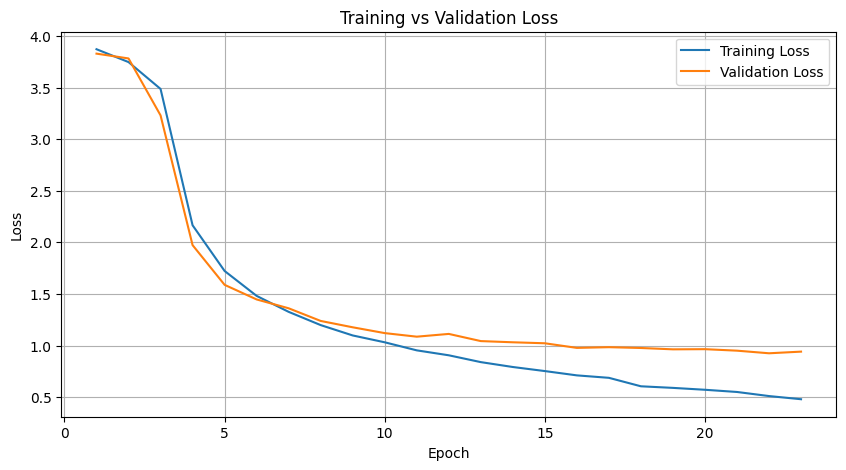

In [ ]:
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def loss_values(event_file):
  ea = event_accumulator.EventAccumulator(event_file)
  ea.Reload()  # loads events from file

  # Extract scalar values
  loss = ea.Scalars('Training vs. Validation Loss')

  steps = [x.step for x in loss]
  vals = [x.value for x in loss]

  return steps, vals

# Change these file paths accordingly
train_file = "/content/events.out.tfevents.1755732591.309c9efb2280.1056.1"
test_file = "/content/events.out.tfevents.1755732591.309c9efb2280.1056.2"

train_steps, train_vals = loss_values(train_file)
test_steps, test_vals = loss_values(test_file)

plt.figure(figsize=(10, 5))
plt.plot(train_steps, train_vals, label='Training Loss')
plt.plot(test_steps, test_vals, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Check model predictions after training using [greedy decoding](https://medium.com/@jessica_lopez/understanding-greedy-search-and-beam-search-98c1e3cd821d).

In [ ]:
#%pip install jiwer
import jiwer

checkpoint = torch.load(
    "/content/checkpoint_20250820_232006_21.pth",
    map_location=torch.device("cpu")
)
model = TinyModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch_number = checkpoint['epoch'] + 1  # continue from next epoch
best_vloss = checkpoint['best_vloss']

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        print(f"Batch # {i+1}")
        # Same code from training steps
        inputs = batch["mfccs"].to(device)
        inputs = inputs.permute(0, 2, 1)
        targets = batch["labels"].to(device)
        input_lengths = ((batch["input_length"] - 11) // 2 + 1).to(device)
        target_lengths = batch["label_length"].to(device)
        outputs = model(inputs)

        # Final layer of model gives log(prob)
        # Extract prob by taking exp
        outputs = torch.exp(outputs)
        pred_indices = torch.argmax(outputs, dim=2) # Take maximum probability

        # Greedy decoder function
        decoded_batch = []
        for b in range(min(1, pred_indices.size(0))):
            pred = pred_indices[b].tolist()
            decoded = []
            previous = None
            for p in pred:
                if p != 0 and p != previous:
                    decoded.append(p)
                previous = p
            decoded_batch.append(decoded)
            true_text = ''.join(int_sequence_to_text(targets[b].cpu().numpy())).replace("<SPACE>", " ")
            decoded_text = ''.join(int_sequence_to_text(decoded)).replace("<SPACE>", " ")
            print(f"True : {true_text}")
            print(f"Pred: {decoded_text}")
            print(f"CER: {jiwer.cer(true_text, decoded_text)*100} %")


Batch # 1
True : እኛ ም ወስፋ ት ይሆናል እያ ልን በኋላ በኋላ ነው ይህ የ ወጣለት
Pred: እኛ ም ወስፋት ይሆና ል እያለ ም በኋላ በኋላ ነው ይህ እይ ወጣለሁ
CER: 19.047619047619047 %
Batch # 2
True : የ ባህር በር ቢ ኖረን ይጠቅ መናል
Pred: የ ባህር በር ቢኖረን ይጠቅም ኗል
CER: 18.181818181818183 %
Batch # 3
True : አገሬ የ መጣሁ አልመሰለ ኝም አፓርታይድ ን አስ ታወሰኝ
Pred: አገር የ መጣፋ ል መሰለኝ ም አፓር ታይድ ን አስታወሰኝ
CER: 22.857142857142858 %
Batch # 4
True : ከዚያ እስከ ዛሬ ድረስ አቶ አብርሀም ያሉበት ን ትግል ና እየከፈሉ ያሉት ንም መስዋእትነት አውቃለሁ አደን ቃለሁ ም
Pred: ከዚ አእስከዛሬ ድረስ አቶ አግርሀም የያሉ በትን ትግለና እየ ከፈሉ ያሉት ን መጽዋእት እነ ታውቃለሁ አደንቃ ለሁ
CER: 27.397260273972602 %
Batch # 5
True : እንዲያ ውም ድርጊቱ ኢትዮጵያ በ ኤርትራ ላይ ሙሉ ወረራ ለማድረግ እንደ ምክንያት የ ም ትጠቀምበት ነው ሲሉ ኮን ነዋል
Pred: ቢያ ውም እዲቱ ኢትዮጵያ በ ኤርትላላይ ሙሉ ወረራል ለ ማረግ እንደ ምክንያት የምት ጠቀመበችውም
CER: 37.333333333333336 %
Batch # 6
True : በ ሶስተኛው ደረጃ ደግሞ አምባገነኑ ን ስርአት በ ስሙ የሚጠራ በመሆኑ ም አብዛኛው ኢትዮጵያዊ ያከብ ረዋል
Pred: በ ሶስተኛው ደረጃ ደግሞ አምባገንኑ ን ስርአት በ ስሙ የሚጠራ በ መሆኑ አብዛኛ ኢትዮጵያዊ ያገብ ሯዋል
CER: 10.44776119402985 %
Batch # 7
True : ኢትዮጵያ በ አለም ቀይ መስቀል ፊት ለፊት በ ግልጽ ለ ደህንነቷ የሚያ ሰጉ ኤርትራውያን ን ለ ማባረር ተገዳ 

Implement quantization which reduces memory allocation of model by utilizing lower accuracy floats and ints.

In [ ]:
# Quantization operation
small_model = torch.ao.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear, torch.nn.GRU},
    dtype=torch.qint8
)

torch.save(small_model, "small_asr.pth")

/tmp/ipython-input-3612154524.py:2: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  small_model = torch.ao.quantization.quantize_dynamic(
